In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
df = pd.read_csv('/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv' , index_col = 0 , parse_dates = True )
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
df.index = df.index.date
df.head()

,Open,High,Low,Close,Volume
2015-04-01,40.60,40.76,40.31,40.72,36865322
2015-04-02,40.66,40.74,40.12,40.29,37487476
2015-04-06,40.34,41.78,40.18,41.55,39223692
2015-04-07,41.61,41.91,41.31,41.53,28809375
2015-04-08,41.48,41.69,41.04,41.42,24753438


In [37]:
df.shape

(1511, 5)

In [5]:
# etude des correlation
df.corr().style.background_gradient(axis = 0)

,Open,High,Low,Close,Volume
Open,1.000000,0.999775,0.999757,0.999541,0.054072
High,0.999775,1.000000,0.999622,0.999731,0.062573
Low,0.999757,0.999622,1.000000,0.999767,0.044514
Close,0.999541,0.999731,0.999767,1.000000,0.052153
Volume,0.054072,0.062573,0.044514,0.052153,1.000000


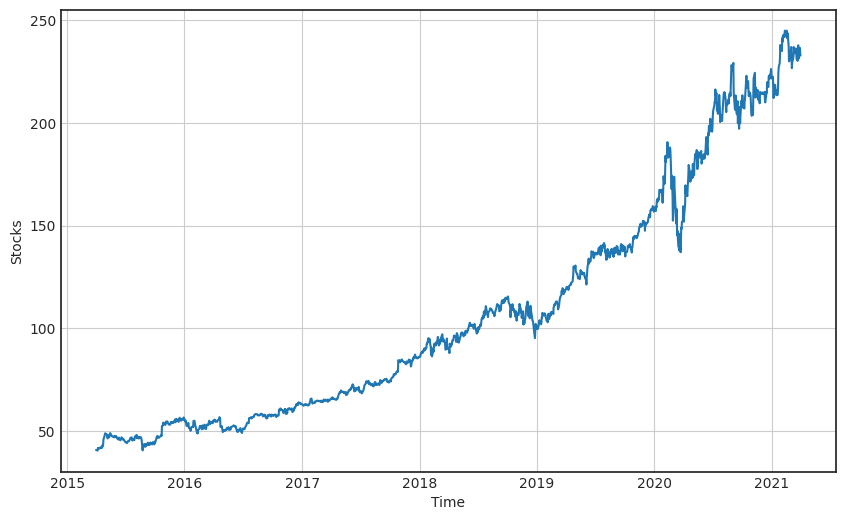

In [12]:
# Representation des données

df.Open.plot()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Stocks')
plt.savefig('time_series_drawn.jpg')
plt.show()

In [14]:
# Decomposition de la serie
from statsmodels.tsa.seasonal import seasonal_decompose

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


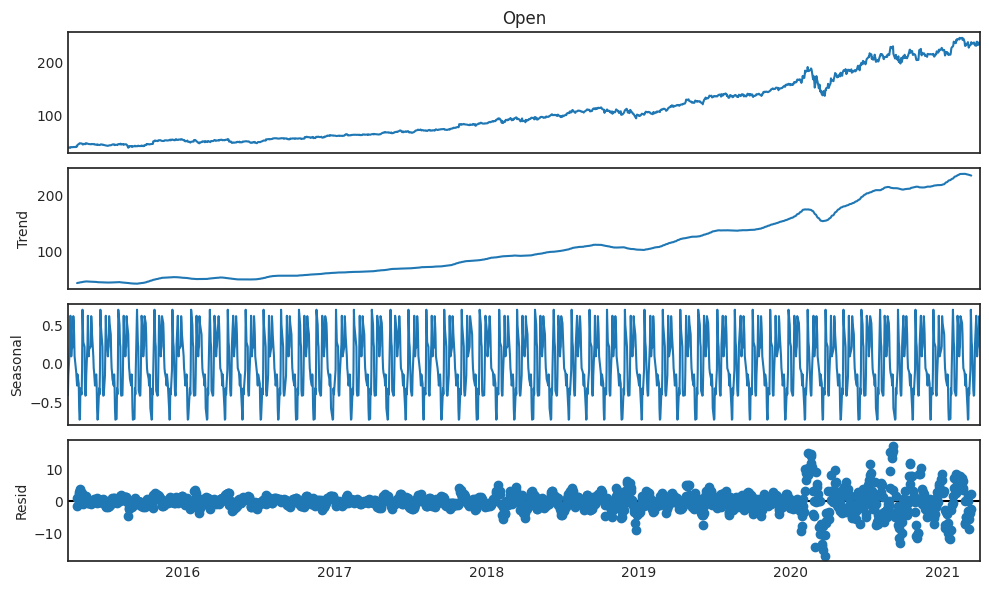

In [15]:
results = seasonal_decompose(df.Open , period = 30)
fig = results.plot()
plt.savefig('Composantes.jpg')

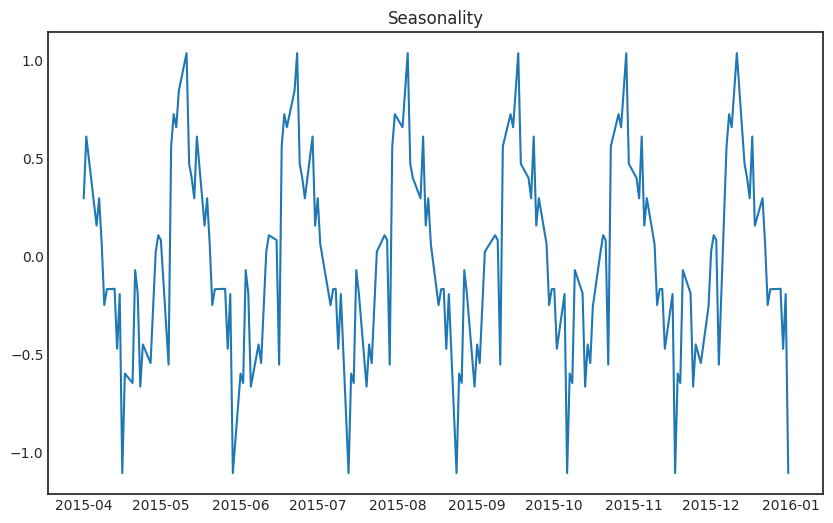

In [25]:
from datetime import date
one_year_df = df[date(2015,1,1):date(2016,1,1)]

results_year = seasonal_decompose(one_year_df.Open , period = 30)
fig = results_year.seasonal.plot()
plt.title('Seasonality')
plt.savefig('seasonality_1.jpg')

# Prophet approach

In [28]:
len_train = len(df)*0.7
len_val = len(df)*0.2
len_test = len(df)*0.1

In [29]:
len_test

151.1

In [30]:
int(len_train+len_val)

1359

In [40]:
train_df = df.iloc[ :int(len_train+len_val)+1 ,:]
test_df = df.iloc[int(len_train+len_val)+1: , :]

In [33]:
from prophet import Prophet
from prophet.plot import plot_plotly

In [41]:
train = train_df.reset_index()[['index','Open']]
train.columns = ['ds','y']

In [42]:
m = Prophet(interval_width = 0.95)
model = m.fit(train)

15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:41 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
future = m.make_future_dataframe(periods = 151)
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-04-01,43.228359,28.935773,47.861150,43.228359,43.228359,-4.263701,-4.263701,-4.263701,0.592525,0.592525,0.592525,-4.856226,-4.856226,-4.856226,0.0,0.0,0.0,38.964658
1,2015-04-02,43.238393,29.982787,49.034218,43.238393,43.238393,-4.077252,-4.077252,-4.077252,0.528576,0.528576,0.528576,-4.605828,-4.605828,-4.605828,0.0,0.0,0.0,39.161141
2,2015-04-06,43.278532,30.498282,49.096418,43.278532,43.278532,-3.269716,-3.269716,-3.269716,0.283199,0.283199,0.283199,-3.552915,-3.552915,-3.552915,0.0,0.0,0.0,40.008816
3,2015-04-07,43.288567,30.785900,50.256635,43.288567,43.288567,-2.576941,-2.576941,-2.576941,0.710624,0.710624,0.710624,-3.287565,-3.287565,-3.287565,0.0,0.0,0.0,40.711626
4,2015-04-08,43.298602,30.816198,50.017072,43.298602,43.298602,-2.432470,-2.432470,-2.432470,0.592525,0.592525,0.592525,-3.024995,-3.024995,-3.024995,0.0,0.0,0.0,40.866132


In [44]:
predictions = pd.Series(forecast.yhat.values , index = forecast.ds)

In [45]:
predictions.shape

(1511,)

<Axes: xlabel='ds'>

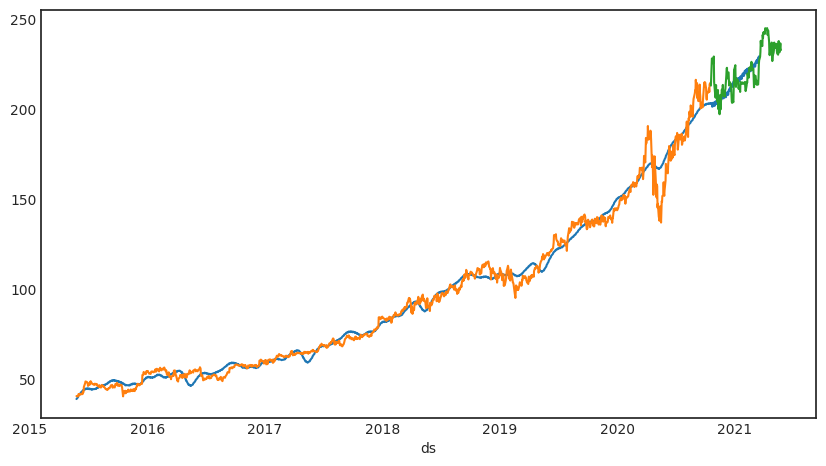

In [46]:
predictions.plot()
train_df.Open.plot()
test_df.Open.plot()


In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(predictions.iloc[-151:],test_df.Open))
rmse

10.451574638432723

In [48]:
plot_plotly(model , forecast)

# ARIMA Approach

In [49]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.1 MB/s eta 0:00:0000:01


In [50]:
from pmdarima import auto_arima

In [51]:
best_model = auto_arima(train_df.Open ,seasonal = True,
                        trace = True,stepwise = True , suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5553.651, Time=3.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5575.620, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5558.143, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5554.660, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5579.926, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5552.463, Time=1.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5550.464, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5552.462, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5551.586, Time=1.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5554.456, Time=0.99 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5558.221, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 9.360 seconds


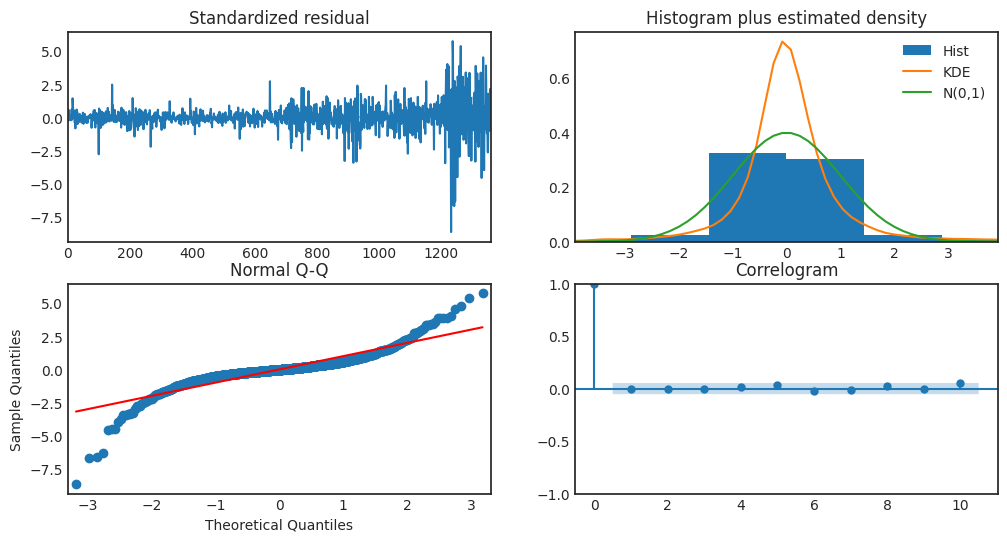

In [52]:
res = best_model.plot_diagnostics(figsize = (12,6))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



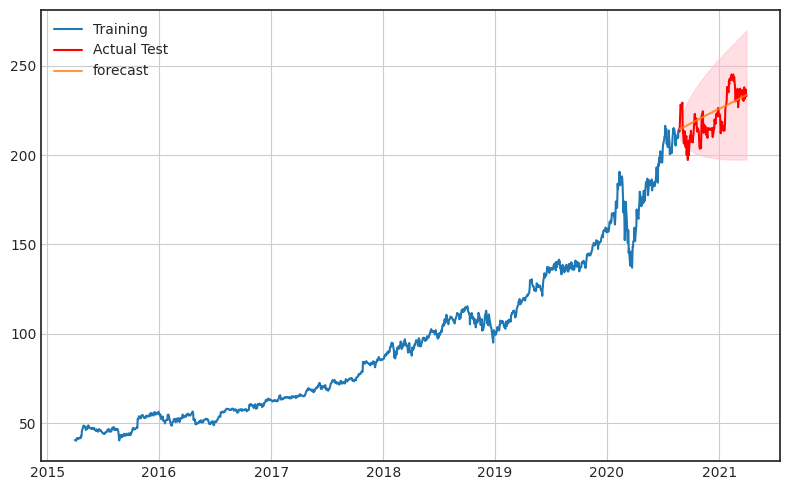

In [53]:
forecast_values , conf_int = best_model.predict(n_periods =  151,return_conf_int = True)


forecast_values =  pd.Series(forecast_values.values , index = test_df.index )
lower_serie = pd.Series( conf_int[:,0] , index = test_df.index  )
upper_serie = pd.Series( conf_int[:,1] , index = test_df.index  )

plt.figure(figsize = (8,5))
train_df.Open.plot(legend = True , label = 'Training' )
test_df.Open.plot(legend = True , label = 'Actual Test' , color = 'red')
forecast_values.plot(legend = True , alpha= 0.8 ,label = 'forecast')
plt.fill_between(test_df.index  , lower_serie , upper_serie , color = 'pink' , alpha = 0.5)
plt.grid()
plt.tight_layout()
plt.show()

In [54]:
rmse = sqrt(mean_squared_error(forecast_values,test_df.Open))
rmse

8.934346103031961

# Using A LSTM

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df[['Open']])
x_train = scaler.transform(train_df[['Open']])
x_test = scaler.transform(test_df[['Open']])

In [56]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [57]:
n_features= 1
n_input = 60

generator = TimeseriesGenerator(x_train,x_train, length= n_input,batch_size = n_features)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dropout , Dense 
from tensorflow.keras.callbacks import EarlyStopping

In [79]:
model =  Sequential()
model.add(LSTM(50 ,input_shape = (n_input ,n_features) , return_sequences = True))
model.add(LSTM(50))
model.add(Dense(16 , activation = 'relu'))
model.add(Dense(1))

model.compile(loss = 'mse' , optimizer = 'Adam' , metrics = 'mae')

In [60]:
early_cb = EarlyStopping(monitor = 'loss' , min_delta=1e-5 , restore_best_weights = True, patience = 20)

In [80]:
history = model.fit(generator , epochs = 100 , callbacks = [early_cb])

Epoch 1/100
1300/1300 [==============================] - 15s 8ms/step - loss: 0.0027 - mae: 0.0301
Epoch 2/100
1300/1300 [==============================] - 10s 8ms/step - loss: 9.6304e-04 - mae: 0.0210
Epoch 3/100
1300/1300 [==============================] - 11s 8ms/step - loss: 6.9496e-04 - mae: 0.0175
Epoch 4/100
1300/1300 [==============================] - 10s 8ms/step - loss: 5.8136e-04 - mae: 0.0165
Epoch 5/100
1300/1300 [==============================] - 10s 8ms/step - loss: 5.8388e-04 - mae: 0.0165
Epoch 6/100
1300/1300 [==============================] - 11s 8ms/step - loss: 3.4301e-04 - mae: 0.0132
Epoch 7/100
1300/1300 [==============================] - 10s 8ms/step - loss: 4.5539e-04 - mae: 0.0135
Epoch 8/100
1300/1300 [==============================] - 11s 8ms/step - loss: 3.6475e-04 - mae: 0.0122
Epoch 9/100
1300/1300 [==============================] - 10s 8ms/step - loss: 2.9804e-04 - mae: 0.0118
Epoch 10/100
1300/1300 [==============================] - 10s 8ms/step - loss

<Axes: >

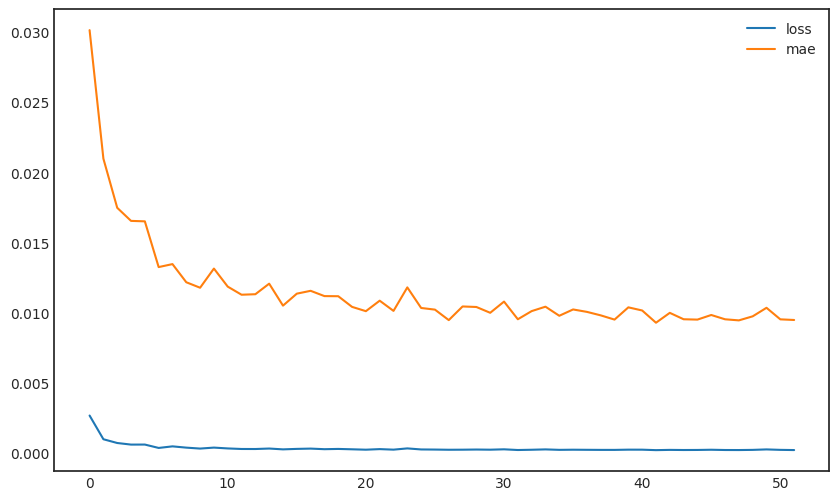

In [81]:
eval_df = pd.DataFrame(history.history)
eval_df[['loss','mae']].plot()


In [82]:
# Creation du dataset de test

test = np.append(x_train[-60:,:1] , x_test)

test_generator = TimeseriesGenerator(test , test , length = n_input , batch_size = n_features)

In [83]:
model.evaluate(test_generator)

151/151 [==============================] - 1s 4ms/step - loss: 6.4404e-04 - mae: 0.0197


[0.0006440352299250662, 0.01965600624680519]

In [84]:
preds = model.predict(test_generator)
test_df['predictions'] = scaler.inverse_transform(preds)

151/151 [==============================] - 1s 3ms/step


/tmp/ipykernel_28/4049148182.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



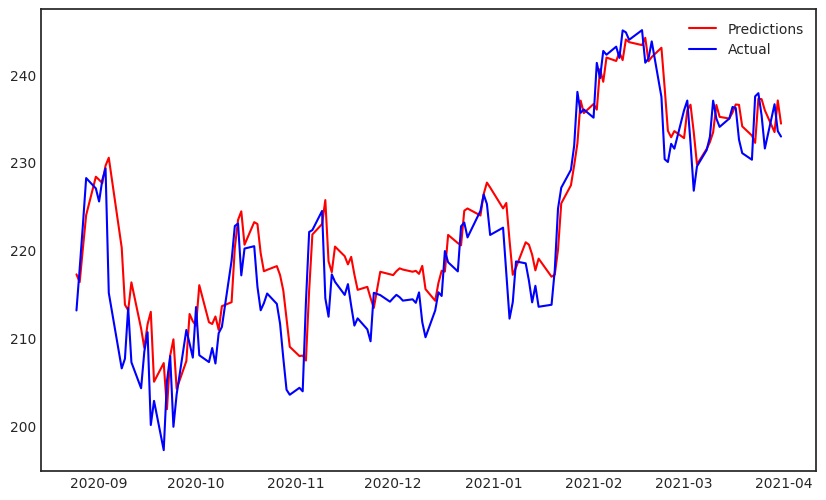

In [85]:
test_df['predictions'].plot(color = 'r')
test_df['Open'].plot(color = 'b')
plt.legend(['Predictions','Actual'])
plt.show()

In [86]:
rmse = sqrt(mean_squared_error(test_df['predictions'],test_df['Open']))
rmse

4.466243239233586

# Conclusion

